---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [103]:
# Load all the random junk 
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from adspy_shared_utilities import plot_class_regions_for_classifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

#Finally got all of the files to read. Buggy class. "refresh until it works" 
training = pd.read_csv("train.csv", encoding = "ISO-8859-1",dtype={'zip_code': str, 'non_us_str_code': str, 'grafitti_status': str})
training.drop(['payment_amount','payment_date','payment_status','balance_due','collection_status','compliance_detail','violation_zip_code','grafitti_status','non_us_str_code','violator_name',
               'mailing_address_str_number','mailing_address_str_name','state','hearing_date','city','zip_code'],axis='columns', inplace=True)
training = training.dropna(subset=['compliance'])
test_data = pd.read_csv("test.csv",encoding = "ISO-8859-1")
test_data.drop(['non_us_str_code','grafitti_status','violation_zip_code','violator_name',
                'mailing_address_str_number','mailing_address_str_name','state','zip_code','hearing_date','city'],axis='columns', inplace=True)
cords = pd.read_csv("latlons.csv")
address = pd.read_csv("addresses.csv")

address1 = cords.merge(address, how='inner',on='address')
train = training.merge(address1, how='inner', on='ticket_id')
test = test_data.merge(address1, how='inner', on='ticket_id')
train = train.dropna(subset=['lat'])




#We need to set the data to categorical




# I know there is a better way to perform these calculations 
train['lat'] = train['lat'].fillna(method='pad') 
train['lon'] = train['lon'].fillna(method='pad') 
test['lat'] = test['lat'].fillna(method='pad') 
test['lon'] = test['lon'].fillna(method='pad') 

In [104]:
train['compliance'].isnull().values.any()


False

In [105]:
test.isnull().values.any()

False

In [106]:
test.isnull().sum()

ticket_id                  0
agency_name                0
inspector_name             0
violation_street_number    0
violation_street_name      0
country                    0
ticket_issued_date         0
violation_code             0
violation_description      0
disposition                0
fine_amount                0
admin_fee                  0
state_fee                  0
late_fee                   0
discount_amount            0
clean_up_cost              0
judgment_amount            0
address                    0
lat                        0
lon                        0
dtype: int64

In [107]:
train.isnull().sum()

ticket_id                  0
agency_name                0
inspector_name             0
violation_street_number    0
violation_street_name      0
country                    0
ticket_issued_date         0
violation_code             0
violation_description      0
disposition                0
fine_amount                0
admin_fee                  0
state_fee                  0
late_fee                   0
discount_amount            0
clean_up_cost              0
judgment_amount            0
compliance                 0
address                    0
lat                        0
lon                        0
dtype: int64

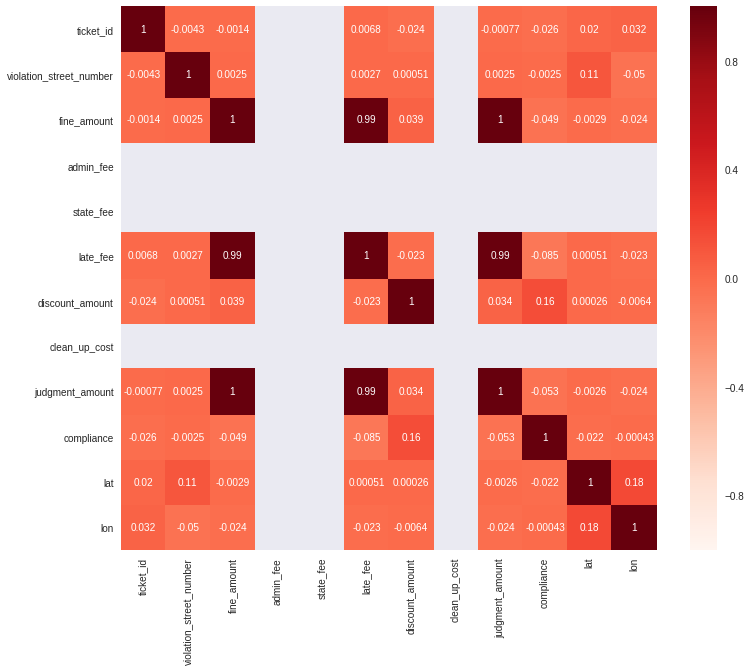

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,10))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [133]:
X = train[['fine_amount', 'discount_amount']]
y = train['compliance']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [137]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.93427570678008509

In [136]:
from sklearn import preprocessing
for df in [train, test]:
    X = df.select_dtypes(include=['object'])
    le = preprocessing.LabelEncoder()
    X_2 = X.astype(str).apply(le.fit_transform)


0.93427570678008509

In [123]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61001 entries, 0 to 61000
Data columns (total 20 columns):
ticket_id                  61001 non-null int64
agency_name                61001 non-null object
inspector_name             61001 non-null object
violation_street_number    61001 non-null float64
violation_street_name      61001 non-null object
country                    61001 non-null object
ticket_issued_date         61001 non-null object
violation_code             61001 non-null object
violation_description      61001 non-null object
disposition                61001 non-null object
fine_amount                61001 non-null float64
admin_fee                  61001 non-null float64
state_fee                  61001 non-null float64
late_fee                   61001 non-null float64
discount_amount            61001 non-null float64
clean_up_cost              61001 non-null float64
judgment_amount            61001 non-null float64
address                    61001 non-null object
la

In [116]:
#process_data = list(train.columns.values)
#process_data.remove('compliance')
#test = test[train_columns]

In [117]:
#ab = process_data.drop(['compliance'], axis=1)

In [125]:
X_train =  
y = process_data.loc[:,'compliance'].values

train['compliance']
train = train[(train["compliance"] == 1) | (train["compliance"] ==0)]

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
from sklearn.linear_model import LogisticRegression

logist = LogisticRegression().fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
print('train size:', X_train.shape)
print('test size: ', y_train.shape)



In [78]:
rf = RandomForestRegressor()

In [79]:
from sklearn.model_selection import train_test_split, GridSearchCV
grid_values = {'n_estimators': [10, 30], 'max_depth': [3, 10]}
grid_rf_auc = GridSearchCV(rf, param_grid=grid_values, scoring='roc_auc')
grid_rf_auc.fit(X_train, y_train)
print('Grid best parameter (max. AUC): ', grid_rf_auc.best_params_)
print('Grid best score (AUC): ', grid_rf_auc.best_score_)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
y_train = train['compliance']

In [ ]:
X_train = train['lat']

In [ ]:
X_test = test

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,...,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,address,lat,lon,cord
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,3.0,S. WICKER,CHICAGO,IL,...,10.0,25.0,0.0,0.0,305.0,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268,"42.390729 , -83.124268"
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,2959.0,Martin Luther King,Detroit,MI,...,10.0,75.0,0.0,0.0,855.0,1.0,"4311 central, Detroit MI",42.326937,-83.135118,"42.3269371 , -83.1351183"
2,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478.0,NORTHFIELD,2755.0,E. 17TH,LOG BEACH,CA,...,10.0,25.0,0.0,0.0,305.0,0.0,"6478 northfield, Detroit MI",42.145257,-83.208233,"42.145257 , -83.208233"
3,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",8027.0,BRENTWOOD,476.0,Garfield,Clinton,MI,...,10.0,75.0,0.0,0.0,855.0,0.0,"8027 brentwood, Detroit MI",42.433466,-83.023493,"42.433466 , -83.023493"
4,18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,8228.0,Mt. Elliott,Detroit,MI,...,10.0,10.0,0.0,0.0,140.0,0.0,"8228 mt elliott, Detroit MI",42.388641,-83.037858,"42.3886415 , -83.0378578"
5,18733,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,8228.0,Mt. Elliott,Detroit,MI,...,10.0,10.0,0.0,0.0,140.0,0.0,"8228 mt elliott, Detroit MI",42.388641,-83.037858,"42.3886415 , -83.0378578"
6,28204,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Inc, Nanno",15307.0,SEVEN MILE,1537.0,E. Seven Mile,Detroit,MI,...,10.0,75.0,0.0,0.0,855.0,0.0,"15307 seven mile, Detroit MI",42.435773,-82.963348,"42.435773 , -82.963348"
7,18743,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Gardner Resale, GAR",9100.0,VAN DYKE,91.0,Van Dyke,Detroit,MI,...,10.0,75.0,0.0,0.0,855.0,0.0,"9100 van dyke, Detroit MI",42.395765,-83.022333,"42.395765 , -83.022333"
8,18741,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Hardaway, Kevin",20024.0,SCHAEFER,224.0,Schaefer,Detroit,MI,...,10.0,75.0,0.0,0.0,855.0,0.0,"20024 schaefer, Detroit MI",42.440190,-83.180488,"42.4401895 , -83.1804877"
9,18978,"Buildings, Safety Engineering & Env Department","Williams, Darrin","TLC Hand Car Wash, a/k/a",9425.0,VAN DYKE,9425.0,Van Dyke,Detroit,MI,...,10.0,75.0,0.0,0.0,855.0,0.0,"9425 van dyke, Detroit MI",42.399222,-83.023161,"42.3992216 , -83.0231607"


In [ ]:
# Need objects. Not the right order. 
#training = training.astype(str)

# Need to sort by just the rows that do exactly what we need
# Doing something too early. Not sure what. But I am really interested to see just how the data picked up  
#training['compliance'] = training['compliance'].replace(np.nan, 2.0)


# Merging the data frames 
#address1 = cords.merge(address, how='inner',on='address')
#train = address1.merge(training, how='inner', on='ticket_id')
#test = test_data.merge(address1, how='inner', on='ticket_id')

# Drop stuff we don't need
#train.drop(['violation_zip_code','payment_date','collection_status','grafitti_status'], axis=1, inplace=True)


# Now time to pre-proccess this data. Import more junk. Why not?

#from sklearn import preprocessing

#label_encoder = preprocessing.LabelEncoder()
#for col in train.columns[train.dtypes =="object"]:
    #train[col] = label_encoder.fit_transform(train[col])
    
    
# Make sure there are no NaN 


In [ ]:

#To see if the data can be broken down into something smaller
def answer_one():
    df1['compliance'] = df1['compliance'].replace(np.nan, 2.0)
    df1['compliance'] = df1['compliance'].replace(np.nan, 2.0)
    return df1

answer_one()


def answer_three():
    X = df1['fine_amount']
    y = df1['compliance']
    
    return X, y
answer_three()
df1['fine_amount']

In [71]:
# import pandas as pd
import numpy as np

def blight_model():
    
    # Your code here
    
    return # Your answer here

In [ ]:
blight_model()